# Dependencias

In [337]:
!pip install deap

You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [338]:
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython import display
import random
from deap import base, creator, tools, algorithms

# Var Globales

In [339]:
# Var Globales

# Movimientos posibles
#              (arriba, abajo, izquierda, derecha)
MOVIMIENTOS = [(0, 1), (0, -1), (-1, 0), (1, 0)]


# Crear un laberinto de 10x10

laberinto = np.zeros((20, 20))

inicio = (0, 0)
salida = (0, 19)
for i in range(1, 19, 4):

  laberinto[0:19, i] = 1

for i in range(3, 20, 4):

  laberinto[1:20, i] = 1



# Fun generales

In [340]:
def mostrar_laberinto():
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    #ax.set_xticklabels(np.arange(0, 10, 1));
    #ax.set_yticklabels(np.arange(0, 10, 1));
    ax.imshow(laberinto.T, cmap='binary')
    plt.gca().invert_yaxis()
    plt.plot(inicio[0], inicio[1], "ro", label="Inicio")
    plt.plot(salida[0], salida[1], "go", label="Salida")
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


def mover(pos, movimiento):
    # Realiza el movimiento (x, y)
    nueva_pos = (pos[0] + movimiento[0], pos[1] + movimiento[1])

    # Verificar si está dentro de los límites y no es una pared
    if 0 <= nueva_pos[0] < laberinto.shape[0] and 0 <= nueva_pos[1] < laberinto.shape[1]:
        if laberinto[nueva_pos] == 0:  # No es una pared
            return nueva_pos
    return pos  # Si no es un movimiento válido, quedarse en el mismo lugar

def mostrar_ruta_pasos(individuo, s=0.01,laberinto=None, inicio=None, salida=None, grid=False):
    generacion = individuo if isinstance(individuo[0], list) else [individuo]

    NOMBRE_MOVIMIENTOS = ['arriba', 'abajo', 'izquierda', 'derecha']
    #pos = inicio
    #camino = [pos]
    #nombre_camino = ['nada']
    #numero_movimiento = ['-']

    # Clear the previous plot
    plt.clf()

    fig, ax = plt.subplots()
    #ax.invert_yaxis()
    for ind in generacion:
        pos = inicio
        camino = [pos]
        for i, movimiento in enumerate(ind):
            pos = mover(pos, MOVIMIENTOS[movimiento])

            camino.append(pos)
            #nombre_camino.append(NOMBRE_MOVIMIENTOS[movimiento])
            #numero_movimiento.append(movimiento)

            # Convert to NumPy array for plotting
            camino_np = np.array(camino)


            # Plot the path up to the current step
            ax.clear()
            if grid:
              ax.set_xticks(np.arange(0, laberinto.shape[1], 1))
              ax.set_yticks(np.arange(0, laberinto.shape[1], 1))
              #ax.set_xticklabels(np.arange(0, 10, 1));
              #ax.set_yticklabels(np.arange(0, 10, 1));
              ax.grid(grid, which='both')
            ax.set_ylim(-1, laberinto.shape[1])
            ax.set_xlim(-1, laberinto.shape[0])
            ax.imshow(laberinto.T, cmap='binary')
            ax.plot(camino_np[:, 0], camino_np[:, 1], "r-")
            ax.plot(-1, -1, "ro", label=f"{i+1}")
            ax.plot(inicio[0], inicio[1], "bo", label="Inicio")  # Start point
            ax.plot(salida[0], salida[1], "go", label="Salida")   # End point
            #ax.plot(pos_anterior[0], pos_anterior[1], "bo", label=f"pos-ant {pos_anterior}", alpha=0.6)   # End point
            ax.plot(pos[0], pos[1], "bx", label=f"pos {pos}")   # End point
            plt.xlabel("Eje X")
            plt.ylabel("Eje Y")

            ax.legend()

            # Update the display

            display.clear_output(wait=True)
            display.display(fig)

            time.sleep(s)
    plt.close(fig)  # Close the figure to prevent further updates
    #plt.show()  # Keep the final plot displayed

def mostrar_ruta_terminada(individuo, laberinto=None, inicio=None, salida=None, grid=False):
    pos = inicio
    camino = [pos]
    for movimiento in individuo:
        pos = mover(pos, MOVIMIENTOS[movimiento])
        camino.append(pos)

    # Convert to NumPy array for plotting
    camino_np = np.array(camino)

    plt.clf()
    fig, ax = plt.subplots()
    if grid:
      ax.set_xticks(np.arange(0, laberinto.shape[1], 1))
      ax.set_yticks(np.arange(0, laberinto.shape[1], 1))
      #ax.set_xticklabels(np.arange(0, 10, 1));
      #ax.set_yticklabels(np.arange(0, 10, 1));
      ax.grid(grid, which='both')
    ax.set_ylim(-1, laberinto.shape[1])
    ax.set_xlim(-1, laberinto.shape[0])
    ax.imshow(laberinto.T, cmap='binary')
    ax.plot(camino_np[:, 0], camino_np[:, 1], "r-")
    ax.plot(inicio[0], inicio[1], "bo", label="Inicio")  # Start point
    ax.plot(salida[0], salida[1], "go", label="Salida")   # End point
    ax.plot(pos[0], pos[1], "bx", label=f"pos {pos}")   # End point
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")

    ax.legend()
    plt.show()
    plt.close(fig)  # Close the figure to prevent further updates


# Correr

## Fun Aptitud

In [341]:
def evaluar_individuo(individual):
    pos = inicio
    esquina = inicio

    for i in range(len(individual)):
        pos_anterior = pos
        pos = mover(pos, MOVIMIENTOS[individual[i]])

        if pos[1] > pos_anterior[1]:
            esquina = pos

    
    penalizacion_esquina = 500 - abs(esquina[0] - pos[0]) 

    # Recompensar avance en Y (cuanto más cerca esté de la salida en Y, mejor)
    recompensa_y = (salida[1] - pos[1]) * 1000



    # Fitness total (menor es mejor)
    fitness = recompensa_y + penalizacion_esquina

    return (fitness,)


# Crear la estructura del algoritmo genético
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar la distancia
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_move", random.randint, 0, len(MOVIMIENTOS)-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_move, n=2000) # 1000 movimientos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluar_individuo)


## Ejecucion

In [ ]:
# Crear la población inicial
pop = toolbox.population(n=1000)  # 100 individuos

# Ejecutar el algoritmo genético
resultados, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=25, verbose=False)

<Figure size 640x480 with 0 Axes>

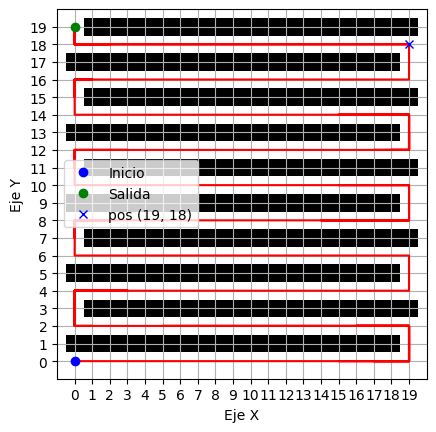

In [ ]:
mostrar_ruta_terminada(resultados[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

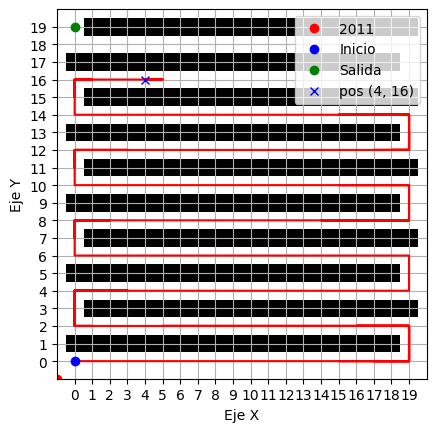

In [ ]:
mostrar_ruta_pasos(resultados[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True, s=0)

# Ver proceso

# Ejecucion 2

<Figure size 640x480 with 0 Axes>

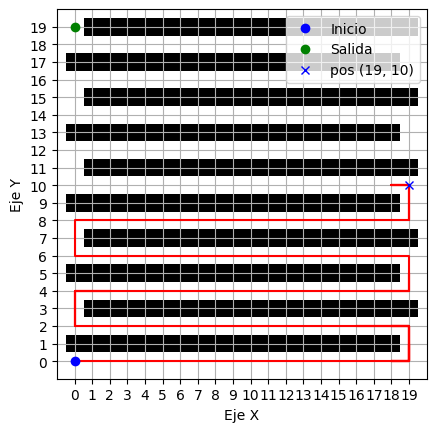

In [ ]:
from deap import tools
# Variables para el registro de la evolución
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

logbook = tools.Logbook()

# Crear la población inicial
pop = toolbox.population(n=100)  # 100 individuos

# Ejecutar el algoritmo genético
resultados, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=50,stats=stats, verbose=False)

# Encontrar el mejor individuo
mejor_individuo = tools.selBest(pop, 1)#[0]
mostrar_ruta_terminada(mejor_individuo[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True)

In [ ]:
# Extraer las estadísticas de cada generación
generaciones = logbook.select("gen")
minimos = logbook.select("min")
promedios = logbook.select("avg")

# Graficar la evolución
import matplotlib.pyplot as plt

plt.plot(generaciones, minimos, label="Mejor aptitud")
plt.plot(generaciones, promedios, label="Aptitud promedio", linestyle="--")
plt.xlabel("Generaciones")
plt.ylabel("Aptitud")
plt.title("Evolución del Algoritmo Genético")
plt.legend()
plt.show()